In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import yfinance as yf
import hvplot.pandas
import mplfinance as mpf
from prophet import Prophet

In [126]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [127]:
#Getting BTC Dataframe

# Define the ticker symbol for Bitcoin
btc_symbol = "BTC-USD"

# Specify the date range for the past 10 years
start_date = "2013-10-09"
end_date = "2025-12-04"

# Use yfinance to get Bitcoin data for the specified date range
btc_data = yf.download(btc_symbol, start=start_date, end=end_date, progress=False)

ohlc_btc = btc_data.copy()

# Extract the "Close" column and create a DataFrame
btc_df = btc_data[["Close"]]

# Print the first few rows of the DataFrame
print(btc_df.head())
print(btc_df.tail())

                 Close
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014
                   Close
Date                    
2024-01-21  41545.785156
2024-01-22  39507.367188
2024-01-23  39845.550781
2024-01-24  40077.074219
2024-01-26  40121.925781


In [128]:
# Plot the closing prices for Bitcoin
btc_df.hvplot.line(
    title="Bitcoin Closing Prices",
    xlabel="Date",
    ylabel="Closing Price ($)",
    width=1000,
    height=400,
)


:Curve   [Date]   (Close)

In [129]:
# Preprocessing Data
bitcoin_data = btc_df.copy()
bitcoin_data = bitcoin_data.dropna()
bitcoin_data.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [130]:
# Show the last five rows
bitcoin_data.tail()

,Close
Date,
2024-01-21,41545.785156
2024-01-22,39507.367188
2024-01-23,39845.550781
2024-01-24,40077.074219
2024-01-26,40121.925781


In [131]:
# Generate synthetic price data
np.random.seed(42)
dates = pd.date_range(start='2013-01-01', end='2023-01-01', freq='D')
prices = 1000 + np.cumsum(np.random.normal(0, 1, len(dates)))

In [132]:
# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Price': prices})
df.set_index('Date', inplace=True)

In [133]:
# Define a simple moving average crossover strategy
class MovingAverageStrategy(nn.Module):
    def __init__(self, short_window, long_window):
        super(MovingAverageStrategy, self).__init__()
        self.short_mavg = nn.Conv1d(1, 1, kernel_size=short_window, stride=1, padding=0)
        self.long_mavg = nn.Conv1d(1, 1, kernel_size=long_window, stride=1, padding=0)

    def forward(self, x):
        short_avg = self.short_mavg(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
        long_avg = self.long_mavg(x.unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0)
        return short_avg, long_avg


In [134]:
# Backtest function
def backtest_strategy(data, strategy, short_window, long_window):
    signals = []
    for i in range(len(data) - max(short_window, long_window)):
        prices_window = torch.tensor(data['Price'].values[i:i+max(short_window, long_window)], dtype=torch.float32)
        short_avg, long_avg = strategy(prices_window)

        if short_avg > long_avg:
            signals.append(1)  # Buy signal
        else:
            signals.append(-1)  # Sell signal

    return signals

In [135]:
# Backtest parameters
short_window = 30
long_window = 90

In [136]:
# Create and train the strategy
strategy = MovingAverageStrategy(short_window, long_window)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(strategy.parameters(), lr=0.001)


In [137]:
# Convert the prices to PyTorch tensor
prices_tensor = torch.tensor(df['Price'].values, dtype=torch.float32)

In [138]:
# Define the backtest_strategy function
def backtest_strategy(data, strategy, short_window, long_window):
    signals = []
    for i in range(len(data) - max(short_window, long_window)):
        prices_window = torch.tensor(data['Price'].values[i:i+max(short_window, long_window)], dtype=torch.float32)
        short_avg, long_avg = strategy(prices_window)

        if short_avg[-1] > long_avg[-1]:
            signals.append(1)  # Buy signal
        else:
            signals.append(-1)  # Sell signal

    return signals

# Backtest the strategy
signals = backtest_strategy(df, strategy, short_window, long_window)



In [139]:
def calculate_sharpe_ratio(returns):
  
    return np.sqrt(252) * (np.mean(returns) / np.std(returns))

def calculate_maximum_drawdown(prices):
    cumulative_returns = np.cumsum(prices)
    max_drawdown = .1
    peak = 10

    for i in range(1, len(cumulative_returns)):
        if cumulative_returns[i] > cumulative_returns[peak]:
            peak = i
        else:
            drawdown = (cumulative_returns[peak] - cumulative_returns[i]) / cumulative_returns[peak]
            max_drawdown = max(max_drawdown, drawdown)

    return max_drawdown

# Extracting returns from signals
df['Returns'] = df['Price'].pct_change().fillna(0)
returns = df['Returns'].tolist()

# Calculating Sharpe Ratio
sharpe_ratio = calculate_sharpe_ratio(returns)

# Calculating Maximum Drawdown
prices_list = df['Price'].values.tolist()
maximum_drawdown = calculate_maximum_drawdown(prices_list)

print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", maximum_drawdown)


Sharpe Ratio: 0.41560381043432676
Maximum Drawdown: 0.8185861393863274


In [140]:
# Visualize the backtest results
df['Signal'] = [0] * max(short_window, long_window) + signals
df['Position'] = df['Signal'].diff()

In [141]:
cdt = df.tail(61)

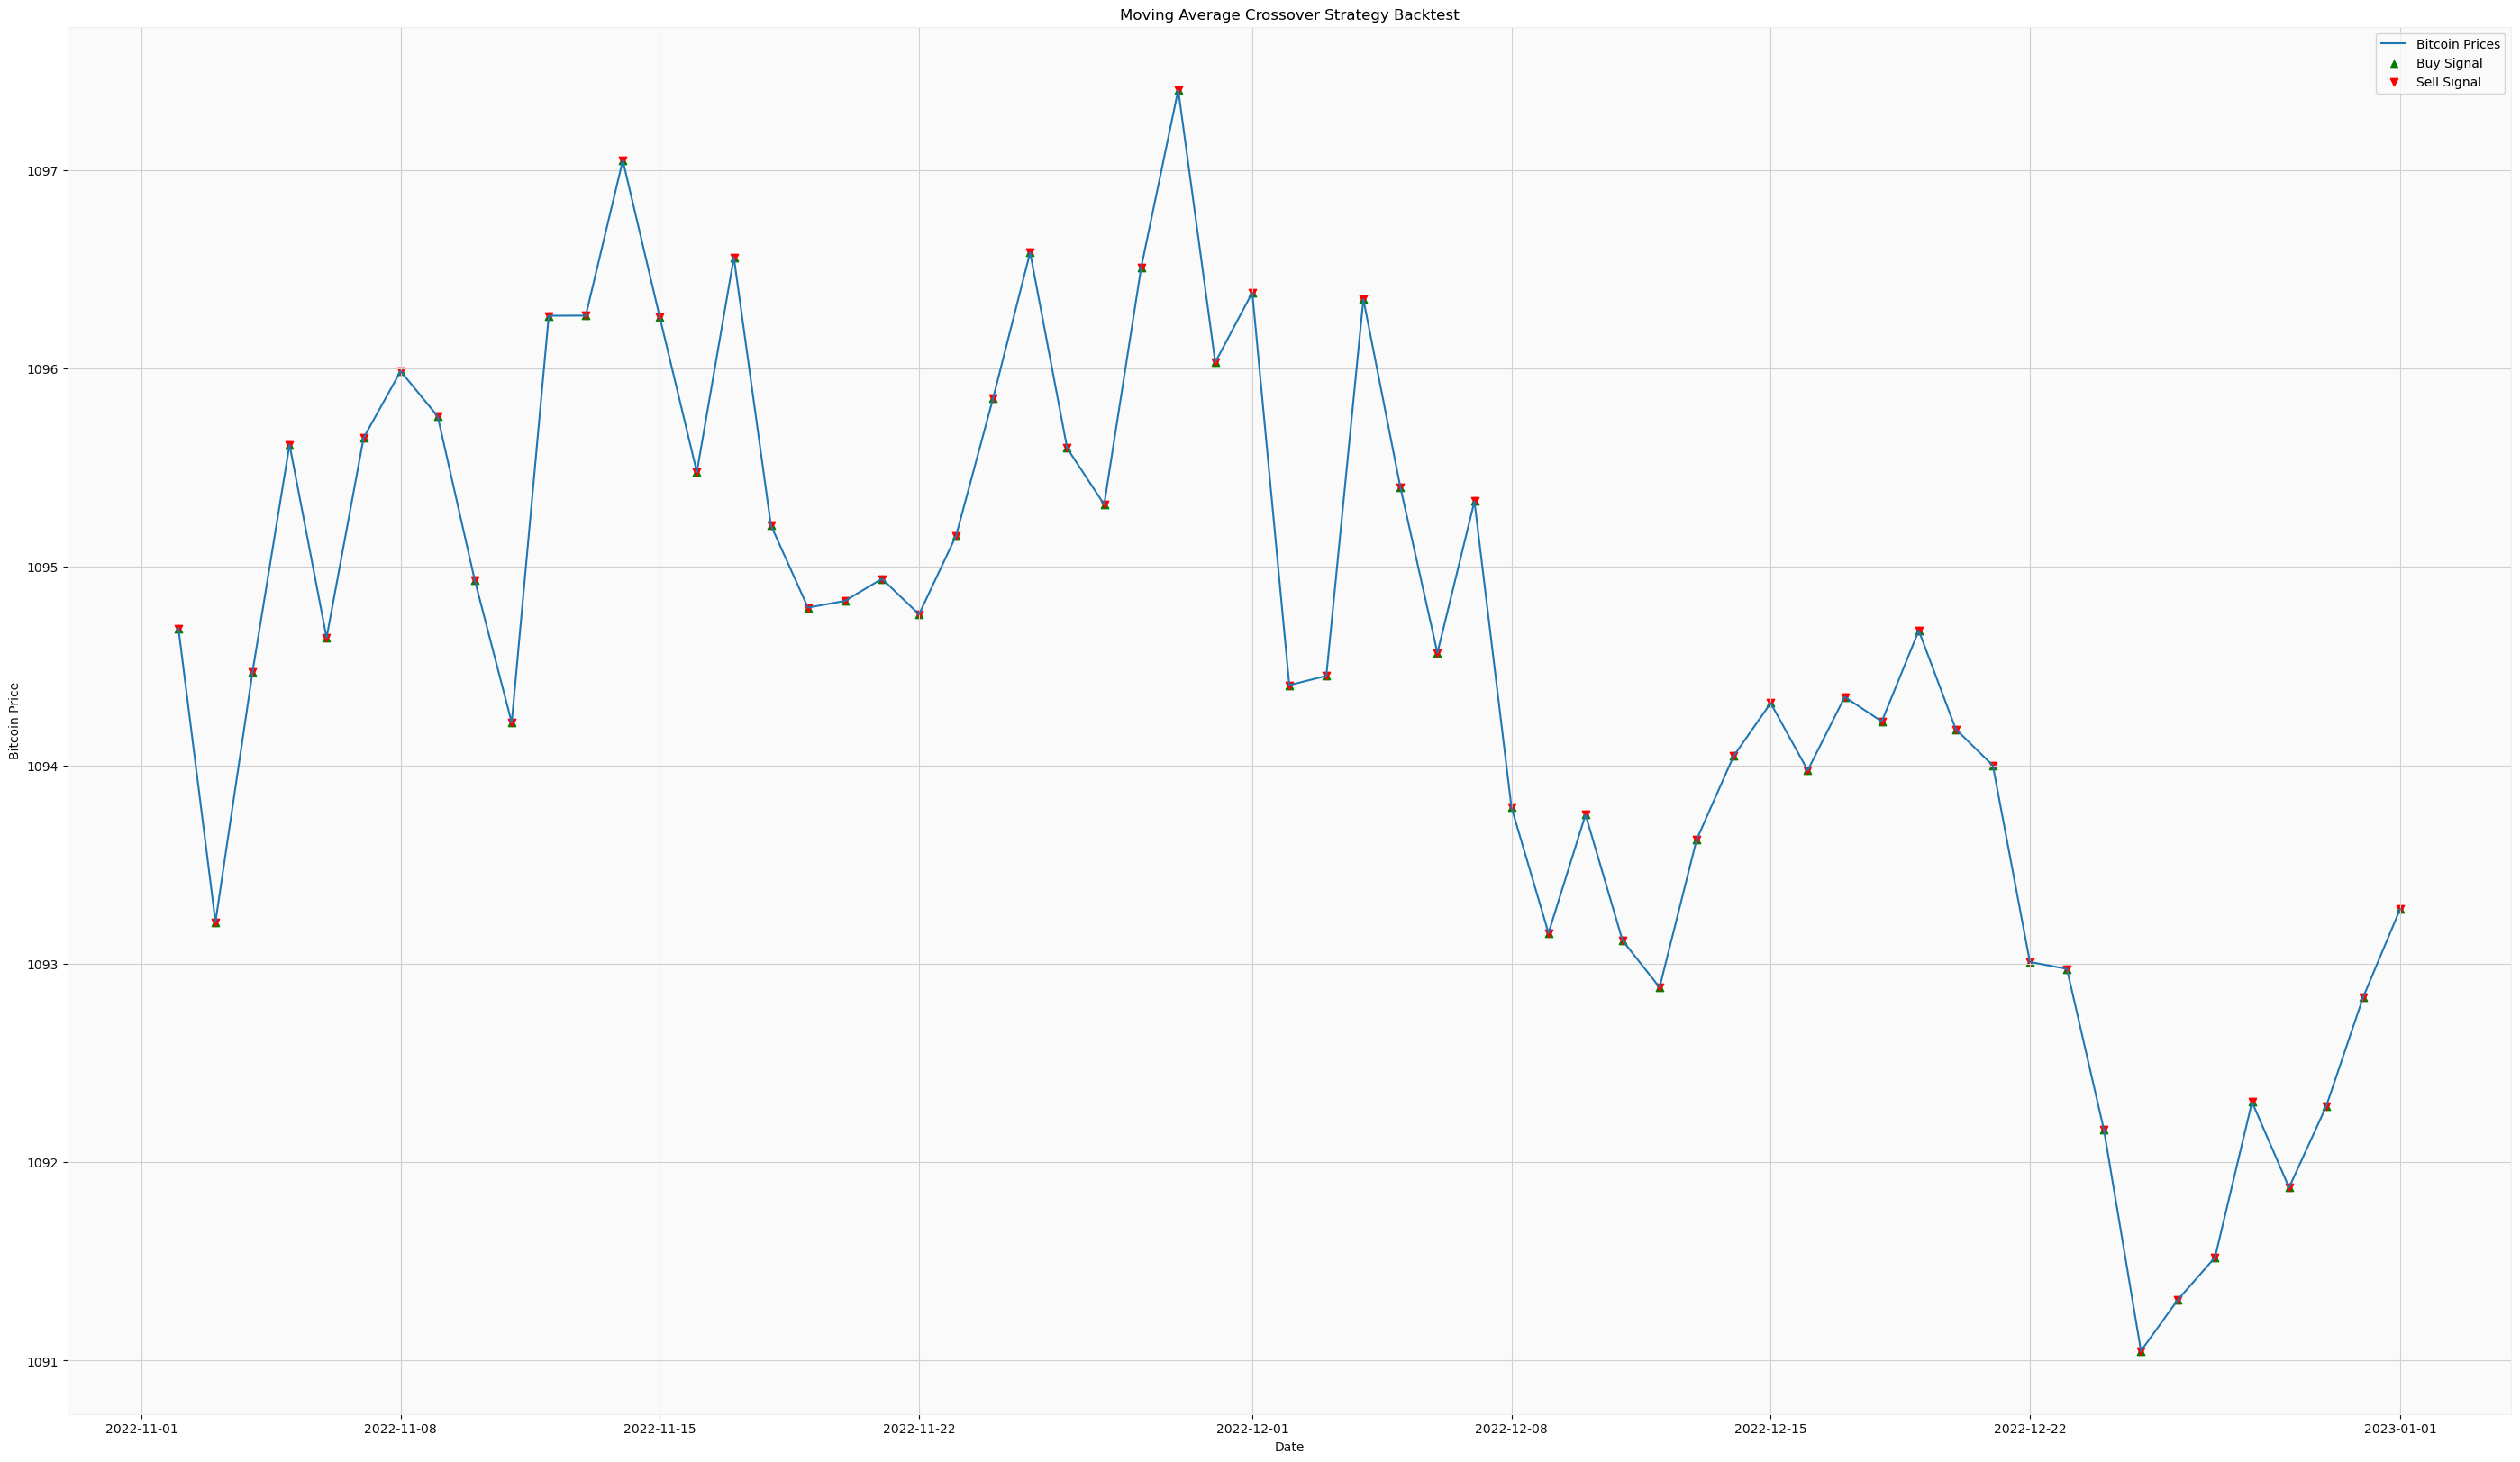

In [142]:
# Plotting for 3 months
plt.figure(figsize=(35, 20))
plt.plot(cdt.index, cdt['Price'], label='Bitcoin Prices')
plt.scatter(cdt.index[cdt['Signal'] == 1], cdt['Price'][cdt['Signal'] == 1], marker='^', color='g', label='Buy Signal')
plt.scatter(cdt.index[cdt['Signal'] == 1], cdt['Price'][cdt['Signal'] == 1], marker='v', color='r', label='Sell Signal')
plt.title('Moving Average Crossover Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

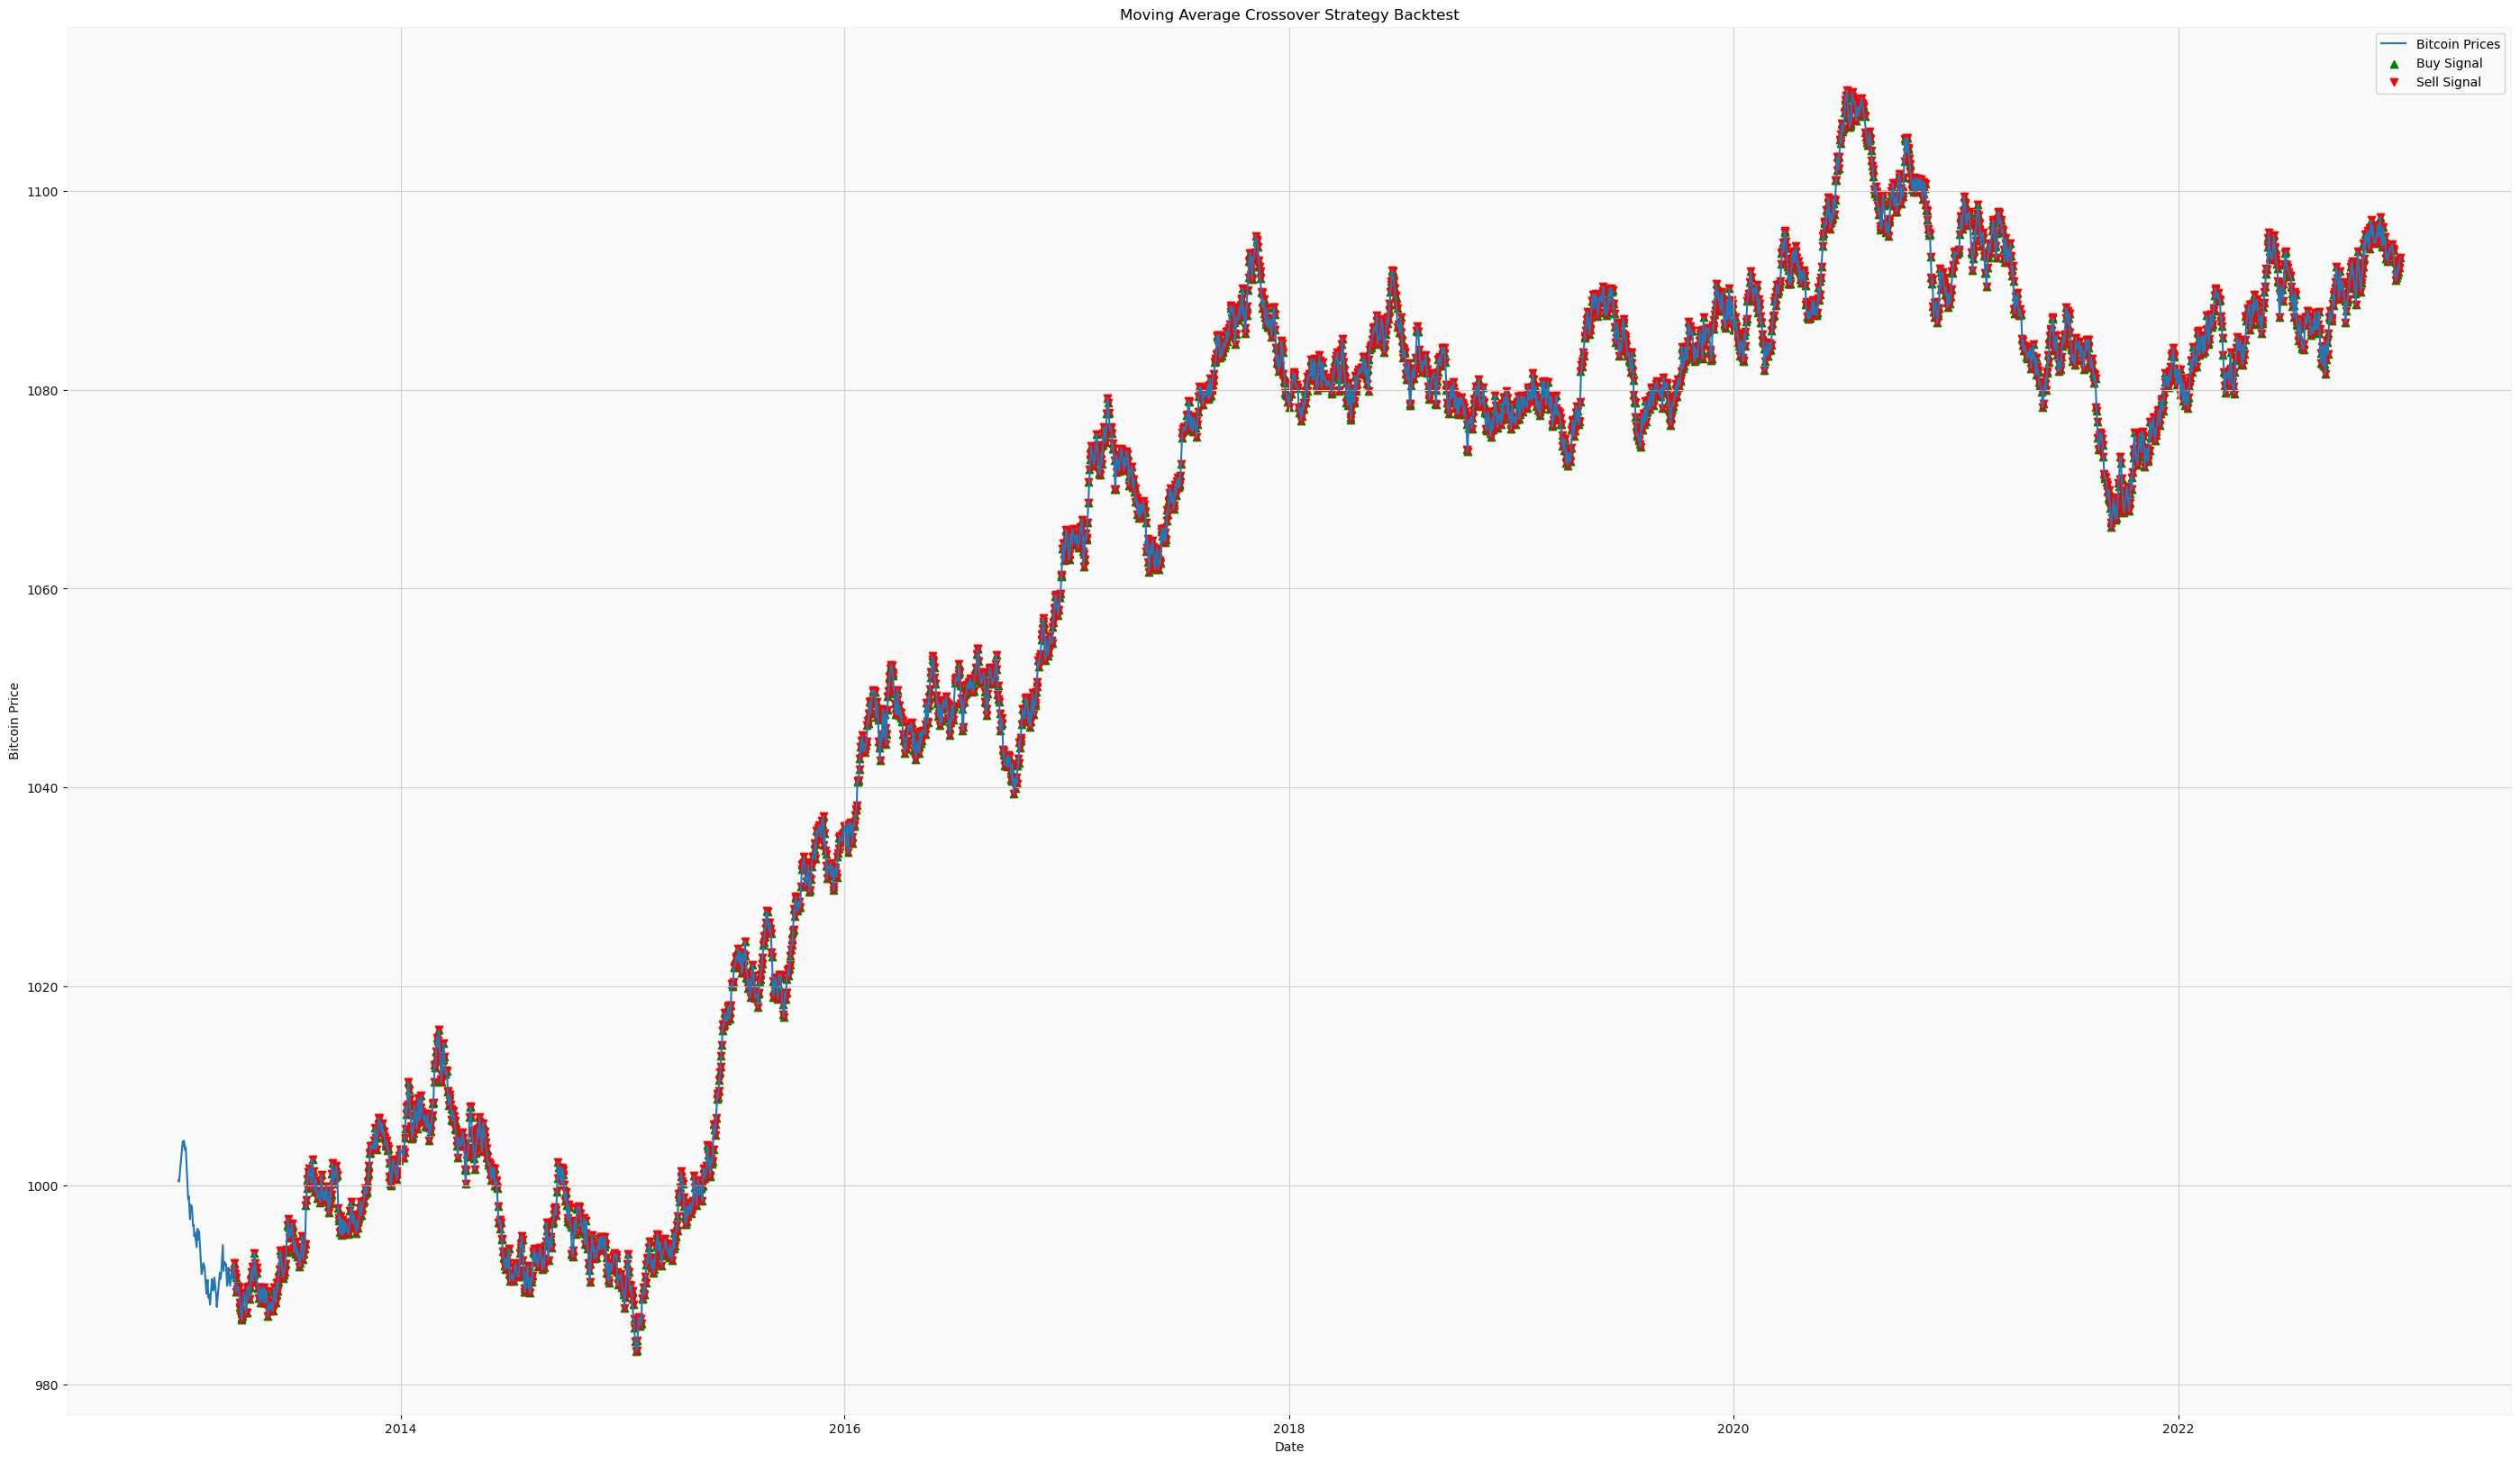

In [143]:
# Plotting for 10 years
plt.figure(figsize=(35, 20))
plt.plot(df.index, df['Price'], label='Bitcoin Prices')
plt.scatter(df.index[df['Signal'] == 1], df['Price'][df['Signal'] == 1], marker='^', color='g', label='Buy Signal')
plt.scatter(df.index[df['Signal'] == 1], df['Price'][df['Signal'] == 1], marker='v', color='r', label='Sell Signal')
plt.title('Moving Average Crossover Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()


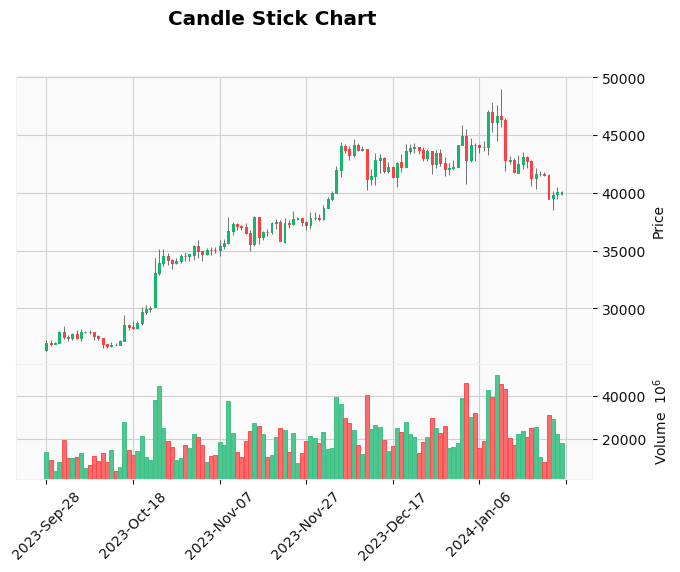

In [144]:
# Suppress the type error with try, except block
try: 
    # Candle Stick Chart
    fig,axes = mpf.plot(ohlc_btc.tail(120), type = "candle", style = "yahoo", title = "Candle Stick Chart", ylabel = "Price", volume = True)
   # Show results
    mpf.show()
except:
    pass


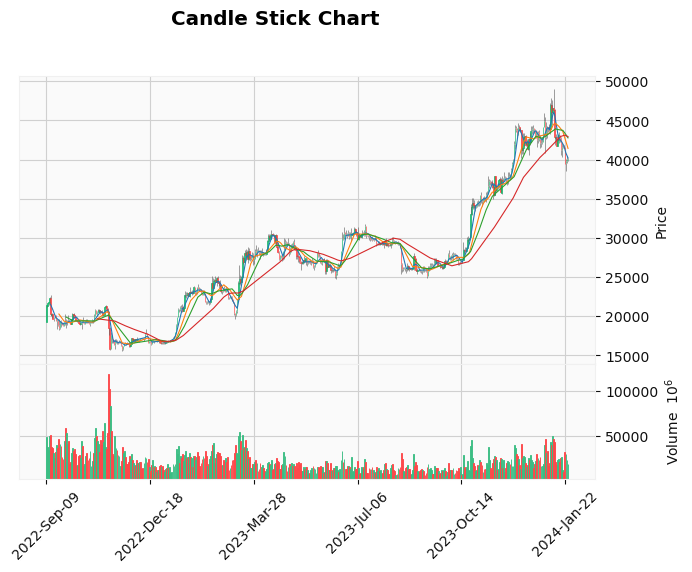

In [145]:
# Suppress the type error with try, except block
try:
    # Candle Stick Chart with MA
    fig,axes = mpf.plot(ohlc_btc.tail(504), type = "candle", style = "yahoo", title = "Candle Stick Chart", ylabel = "Price", volume = True, mav = (5,13,20,50))
   # Show results
    mpf.show()
except:
    pass

In [146]:
btc_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-01-21,41671.488281,41855.367188,41497.007812,41545.785156,41545.785156,9344043642
2024-01-22,41553.652344,41651.207031,39450.117188,39507.367188,39507.367188,31338708143
2024-01-23,39518.714844,40127.351562,38521.894531,39845.550781,39845.550781,29244553045


In [147]:
#Reset Index
btc_data.reset_index(inplace= True)
btc_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
3413,2024-01-21,41671.488281,41855.367188,41497.007812,41545.785156,41545.785156,9344043642
3414,2024-01-22,41553.652344,41651.207031,39450.117188,39507.367188,39507.367188,31338708143
3415,2024-01-23,39518.714844,40127.351562,38521.894531,39845.550781,39845.550781,29244553045
3416,2024-01-24,39877.593750,40483.785156,39508.796875,40077.074219,40077.074219,22359526178


In [148]:
# Isolate the closing price and the date
data = btc_data[["Date", "Close"]]
#Rename columns to align with the Prophet model
data= data.rename(columns={"Date":"ds", "Close": "y"})
data


,ds,y
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3413,2024-01-21,41545.785156
3414,2024-01-22,39507.367188
3415,2024-01-23,39845.550781
3416,2024-01-24,40077.074219


In [149]:
#Initilizing and fit the prophet model
model= Prophet()
model.fit(data)

21:03:43 - cmdstanpy - INFO - Chain [1] start processing
21:03:44 - cmdstanpy - INFO - Chain [1] done processing


In [150]:
# Make predictions
future_trends= model.make_future_dataframe(periods=1000,freq="H")
#View the last five rows of the dataframe
future_trends.tail()


,ds
4413,2024-03-07 12:00:00
4414,2024-03-07 13:00:00
4415,2024-03-07 14:00:00
4416,2024-03-07 15:00:00
4417,2024-03-07 16:00:00


In [158]:
#Make predictions for the trend using the future trend dataframe
forecast_trends= model.predict(future_trends)
# View the last five rows of the dataframe
forecast_trends.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
4413,2024-03-07 12:00:00,29874.328685,25345.323578,37597.926638,29745.430070,29971.668969,1637.637866,1637.637866,1637.637866,-31.707961,-31.707961,-31.707961,1669.345827,1669.345827,1669.345827,0.0,0.0,0.0,31511.966551
4414,2024-03-07 13:00:00,29874.434073,24927.715361,37790.851052,29744.176501,29975.049594,1639.535622,1639.535622,1639.535622,-29.740468,-29.740468,-29.740468,1669.276090,1669.276090,1669.276090,0.0,0.0,0.0,31513.969695
4415,2024-03-07 14:00:00,29874.539462,25014.208130,37467.703680,29742.922932,29977.694037,1641.661742,1641.661742,1641.661742,-27.563296,-27.563296,-27.563296,1669.225037,1669.225037,1669.225037,0.0,0.0,0.0,31516.201203
4416,2024-03-07 15:00:00,29874.644850,25396.922938,38003.638669,29741.669364,29979.077828,1643.986288,1643.986288,1643.986288,-25.206431,-25.206431,-25.206431,1669.192719,1669.192719,1669.192719,0.0,0.0,0.0,31518.631139
4417,2024-03-07 16:00:00,29874.750238,25146.730486,37976.583988,29740.415795,29980.461619,1646.477656,1646.477656,1646.477656,-22.701527,-22.701527,-22.701527,1669.179183,1669.179183,1669.179183,0.0,0.0,0.0,31521.227894


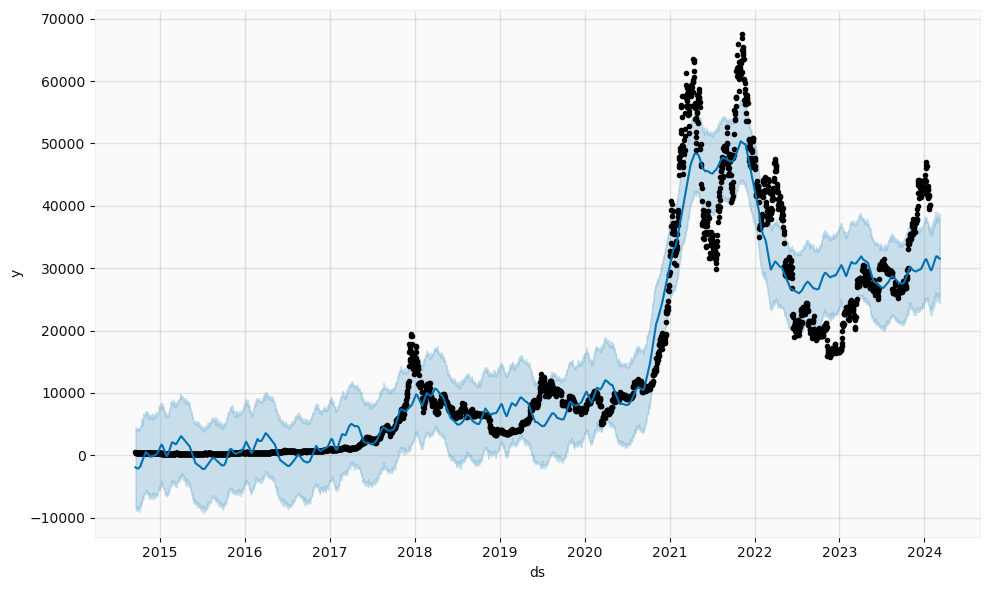

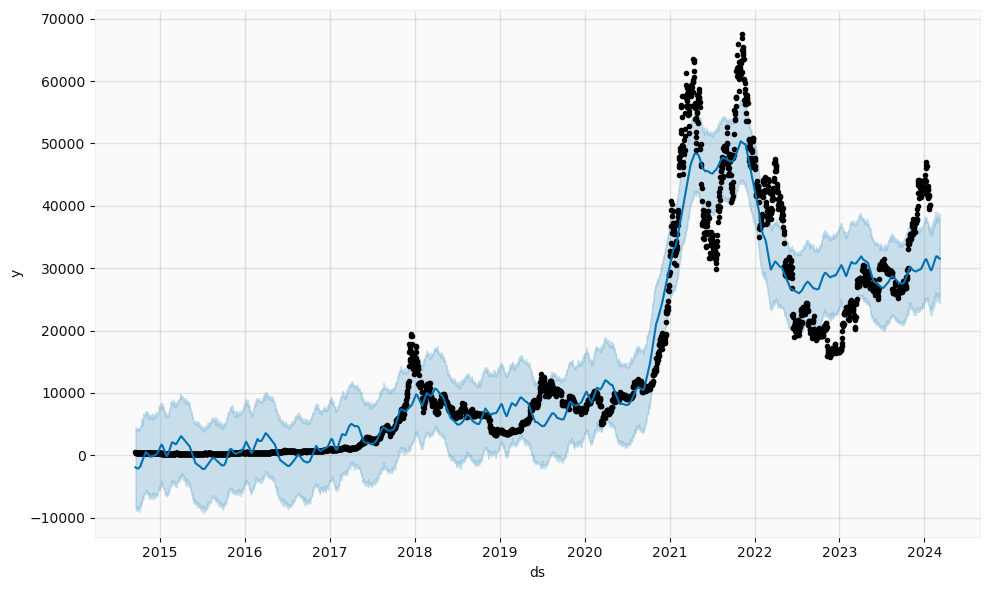

In [152]:
#Plot the prophet prediction for bitcoin data
model.plot(forecast_trends)


In [153]:
#Set the index to the DS datetime column
forecast_trends= forecast_trends.set_index("ds")
#View only the yhat, yhat_lower, and the yhat_upper columns from the Dataframe
forecast_trends[["yhat","yhat_lower","yhat_upper"]].head()

,yhat,yhat_lower,yhat_upper
ds,,,
2014-09-17,-1949.286099,-8246.562043,4452.309210
2014-09-18,-2041.564634,-8575.247128,4376.459838
2014-09-19,-2026.848082,-8777.379125,4297.707622
2014-09-20,-2049.524271,-8176.309350,3967.866917
2014-09-21,-2070.955368,-8395.468618,4230.776291


#Forecast Legend

**yhat** : most likely case

**yhat_lower** : worst case

**yhat_upper** : best case


In [154]:
#Visulize forecast trends using hvplot
forecast_trends[["yhat","yhat_lower","yhat_upper"]].iloc[-1000:,:].hvplot()

:NdOverlay   [Variable]
   :Curve   [ds]   (value)

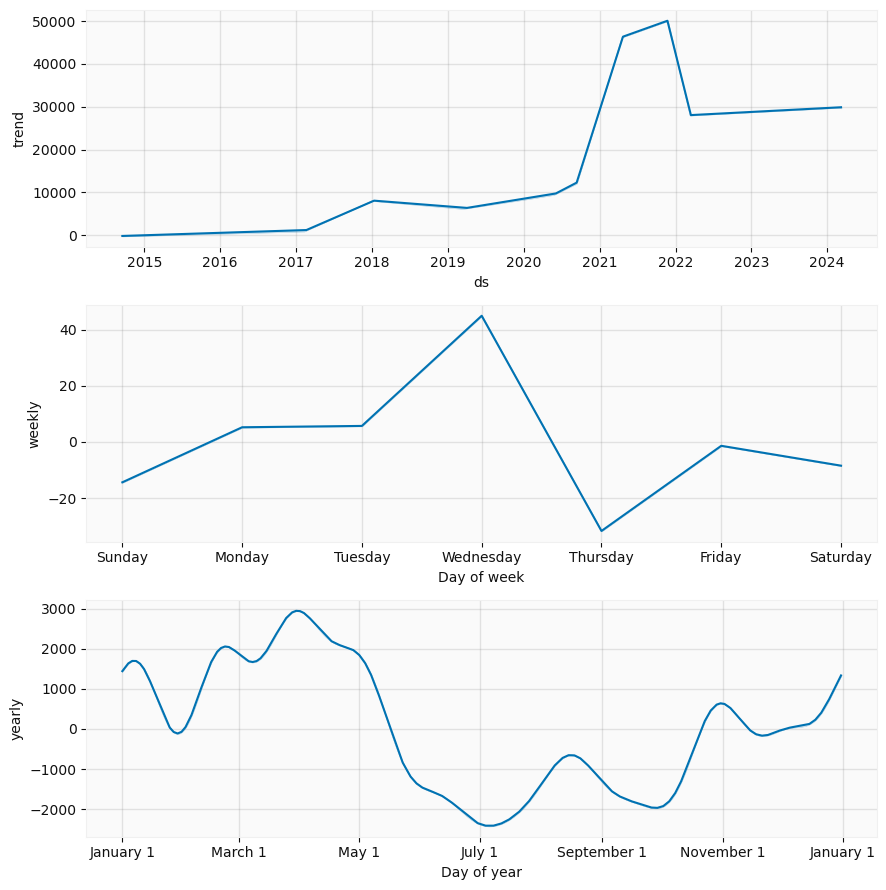

In [155]:
#reset the index in the forecast dataframe
forecast_trends= forecast_trends.reset_index()
#use the plot components function to visulize the forecast results
figures_trend= model.plot_components(forecast_trends)

In [156]:
#forecast_trends.ds.apply(lambda x: x.strftime"%Y-%m-%d %H:%M:%S") 

In [157]:
#create a forecast quoter dataframe for the q4 period of 2023
#forecast_quarter= forecast_trends["2023-10-01":"2023-12-31"]["yhat_upper","yhat_lower","yhat"]
#upate the column names for forecast_quoter
#forecast_quarter=forecast_quarter.rename(columns={"yhat_upper":"Best Case","yhat_lower":"Worst Case", "yhat":"Most Lilely Case"})
#View the last five rows for forecast_quarter
#forecast_quarter.tail()
